In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [2]:
torch.cuda.empty_cache()

In [3]:
torch.cuda.is_available()

True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# AE Arch

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
      
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)

    def forward(self, x):
        
        
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        
        # print(x.shape)
        # x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 4096)

        self.unpool  = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = x.view(x.size(0), 256, 4, 4)
        # x = self.unpool(x)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.sigmoid(self.conv4(x))
        # print(x.shape)
        return x

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()    
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(4*4*256, 4096)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(-1, 4*4*256)
        x = self.fc(x)
        return x
    
    
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(4096, 4*4*256)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 4, 4)
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.sigmoid(self.deconv4(x))
        return x

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [9]:
from tqdm import tqdm

# AE Training

In [10]:
def train(autoencoder, data, epochs=35):
    opt = torch.optim.Adam(autoencoder.parameters(), amsgrad=True)
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            
            x = x.to(device) # GPU
            
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

# Date Loading

In [11]:
latent_dims = 4096
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder('./custom_cartoons/',
               transform=torchvision.transforms.Compose([torchvision.transforms.Resize((64,64)), torchvision.transforms.ToTensor()]),
        ),
        batch_size=1200, 
        shuffle=True)

autoencoder = train(autoencoder, data)

100%|██████████| 35/35 [18:58<00:00, 32.53s/it]


In [14]:
for x, y in data:
    print(x.shape)
    break

torch.Size([1200, 3, 64, 64])


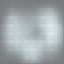

In [15]:
z = torch.rand((1, 4096))
z = z.to(device)
res = autoencoder.decoder(z)
torchvision.transforms.ToPILImage()(res[0])

In [16]:
z.shape

torch.Size([1, 4096])

In [17]:
res = autoencoder.decoder(z)

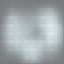

In [18]:
torchvision.transforms.ToPILImage()(res[0])

# VAE

In [19]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        """
        Implement Variational Encoder, use whatever you want
        """
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(4096, 512)
        self.linear2 = nn.Linear(512, latent_dims) # mu
        self.linear3 = nn.Linear(512, latent_dims) # sigma


        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
      
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 1024)


        self.N = torch.distributions.Normal(0, 1) # psi
        self.kl = 0 # kld

    def forward(self, x):

        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))

        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu.to(device) + sigma*self.N.sample(mu.shape).to(device)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [20]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [21]:
def train_vae(autoencoder, data, epochs=25):
    opt = torch.optim.Adam(autoencoder.parameters(), amsgrad=True)
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [22]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train_vae(vae, data)


100%|██████████| 25/25 [13:28<00:00, 32.33s/it]


In [23]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu')

    w = 64
    img = np.zeros((w, n*w, 3))
    for i, x_hat in enumerate(interpolate_list):
        print(x_hat.shape)
        img[:, i*w:(i+1)*w] = np.array(torchvision.transforms.ToPILImage()(x_hat)) / 255
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [24]:
x, y = next(data.__iter__()) 
x_1 = x[0].unsqueeze(0).to(device) 
x_2 = x[1].unsqueeze(0).to(device) 

# Compare AE and VAE Interpolations
- Which is better? 
- Why? 
- Ответ буду читац глазами, лучше подкрепить картинками и объяснениями

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


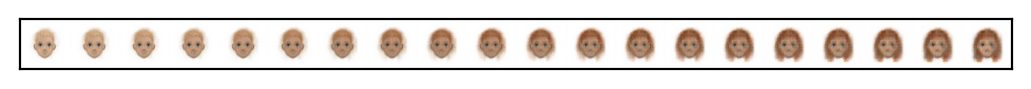

In [25]:
interpolate(vae, x_1, x_2, n=20)


torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


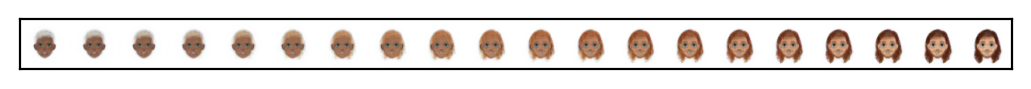

In [26]:
interpolate(autoencoder, x_1, x_2, n=20)


torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


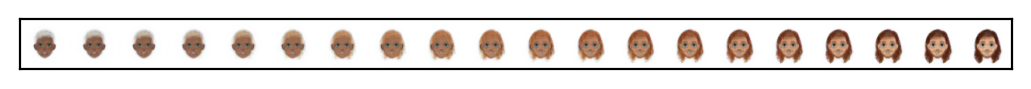

In [27]:
def my_interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu')

    w = 64
    img = np.zeros((w, n*w, 3))
    for i, x_hat in enumerate(interpolate_list):
        print(x_hat.shape)
        img[:, i*w:(i+1)*w] = np.array(torchvision.transforms.ToPILImage()(x_hat)) / 255
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    return img

img = my_interpolate(autoencoder, x_1, x_2, n=20)
plt.imsave('interpolate.png', img)

In [28]:
torch.cuda.empty_cache()